In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

import setup.input_functions as setfun

# Normal regression model
## Background: Case Study
We focus on an experiment conducted by Unkelbach & Rom (2020), where participants are presented with general knowledge statements in two consecutive phases. During the second phase, they are required to indicate whether each statement is true or false. The response variable of interest is the proportion of true judgments (PTJs). The main objective of the study is to investigate the influence of two factors on PTJs: (1) repetition (ReP), which involves presenting some statements from the first phase again in the second phase, and (2) encoding depth (EnC), where participants are divided into groups varying in the level of elaboration required for initial sentence processing in the first phase. We consider a 2 (ReP: repeated, new) $\times$ 3 (EnC: shallow, standard, deep) between-subject factorial design with treatment contrasts used for both factors. The baseline levels are set as new for ReP and deep for EnC. 

**Reference:**

Unkelbach, C., & Rom, S. C. (2017). A referential theory of the repetition-induced truth effect. *Cognition*, 160, 110-126.

## Data generating model
\begin{align*}
    y_i &\sim \text{Normal}(\theta_i, s)\\
    \theta_i &= \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots, 5\\
    s &\sim \text{Gamma}(\alpha, \beta)
\end{align*}
Here, $𝑦_𝑖$ represents the responses for each observation $𝑖 = 1, \ldots , 𝑁$, assumed to follow a normal distribution with mean $\theta_𝑖$ and standard deviation $𝑠$. The expected value $\theta_𝑖$ is modeled as a linear function of two categorical predictors, ReP and EnC. The regression coefficients $\beta_𝑘$ for $𝑘 = 0, \ldots , 5$ are assigned normal prior distributions. Specifically, $\beta_0$ represents the PTJs for condition new-deep, while $\beta_1$ represents the difference in PTJs ($\Delta$PTJ) between repeated and new statements. Additionally, $\beta_2$ captures the $\Delta$PTJ for new statements in the shallow- vs. standard-encoding condition, $\beta_3$ represents the $\Delta$PTJ for new statements in the shallow- vs. deep-encoding condition, and $\beta_4$ and $\beta_5$ account for the interaction effects between ReP and EnC. The standard deviation 𝑠 of the normal likelihood follows a Gamma prior distribution with concentration $\alpha$ and rate parameter $\beta$.

## Methodology: Workflow

+ For each mini-batch:
    + $i$ observations with $i = 1, \ldots, N$, 
    + $k$ regression coefficients with $k = 0,\ldots,6$,
    + $s$ samples from each prior distribution with $s=1,\ldots, M$
    + $g$ group means with $g = 1,\ldots,6$ (corresponding to a $2 \times 3$ factorial design

+ PriorSamples($\lambda = (\mu_k, \sigma_k, \nu)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\{s\}_s &\sim \text{Gamma}(\alpha, \beta)
\end{align*}
+ Generator($\beta_k, s$):
\begin{align*}
\{\theta_i\}_s &= \{\beta_k\}_s \times X_i\\
\bar{s} &= \frac{1}{M} \sum_{i=1}^M \{s\}_s\\
\{y_i\}_s &\sim \text{Normal}(\{\theta_i\}_s, \bar{s})\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{align*}
\{\bar{y}_{g}\}_s &= \frac{1}{N_{g}} \sum_{i=1}^{N_{g}} \{y_i\}_s \quad \text{ for } g = 1,\ldots,6\\
\{\Delta_{eff}\}_s &= \{\bar{y}_{g1}\}_s - \{\bar{y}_{g2}\}_s \quad \text{ for } g1 = 3,4,5 \text{ and } g2 = 0,1,2\\
\{R^2\}_s &= \frac{Var(\{\theta_i\}_s)}{Var(\{y_i\}_s)} 
\end{align*}
+ Elicits($\{\bar{y}_{g}\}_s, \{\Delta_{eff}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Quantile-based:} \quad &Q_p^{g} = Q_{p}^{g} \{y_i\}_s \quad \text{ for } g = 1,\ldots, 6, p = 0.1, \ldots, 0.9\\
\text{Quantile-based:} \quad &Q_p^{eff} = Q_{p}^{eff} \{\Delta_{eff}\}_s \quad \text{ for } eff = 1,2,3; p = 0.1, \ldots, 0.9\\
\text{Histogram-based:} \quad &\{R^2\}_s =\{R^2\}_s 
\end{align*}

## Setting up method

### Model parameters
First, we need to specify the parameters in the generative model using the `param()` function which requires the following input:
+ `name`: the name of the model parameter
    + In our model we have seven model parameters which we will denote as *b0*,*b1*,*b2*,*b3*,*b4*,*b5*,*b6*,*sigma*
+ `family`: the prior distribution family
    + We assume normal prior distributions for each regression coefficient and a gamma distribution for the random noise *sigma* 
    + We created a wrapper around the distributions as implemented in tensorflow-probability in order to learn the hyperparameters on the log-scale.
+ `hyperparams_dict`: a dictionary including the name of the hyperparameter values and the initial value for the learning algorithm
    + We use distributions from which an initial value is drawn.
    + When a hyperparameter is learned on the log-scale, we indicate this by writing "log_" before the actual name of the hyperparameter, such as *log_sigma0*.

In [3]:
from user_input.custom_functions import Normal_log
from user_input.custom_functions import Gamma_log

normal_log = Normal_log()
gamma_log = Gamma_log()

def model_params():  
    return (
        setfun.param(name = "b0", 
              family = normal_log, 
              hyperparams_dict = {"mu0": tfd.Normal(0.,0.1), 
                                  "log_sigma0": tfd.Uniform(-2.,-4.)}
              ),
        setfun.param(name = "b1", 
              family = normal_log, 
              hyperparams_dict = {"mu1": tfd.Normal(0.,0.1), 
                                  "log_sigma1": tfd.Uniform(-2.,-4.)}
              ),
       setfun.param(name = "b2", 
              family = normal_log, 
              hyperparams_dict = {"mu2": tfd.Normal(0.,0.1), 
                                  "log_sigma2": tfd.Uniform(-2.,-4.)}
              ),
        setfun.param(name = "b3", 
              family = normal_log, 
              hyperparams_dict = {"mu3": tfd.Normal(0.,0.1), 
                                  "log_sigma3": tfd.Uniform(-2.,-4.)}
              ),
        setfun.param(name = "b4", 
              family = normal_log, 
              hyperparams_dict = {"mu4": tfd.Normal(0.,0.1), 
                                  "log_sigma4": tfd.Uniform(-2.,-4.)}
              ),
        setfun.param(name = "b5", 
              family = normal_log, 
              hyperparams_dict = {"mu5": tfd.Normal(0.,0.1), 
                                  "log_sigma5": tfd.Uniform(-2.,-4.)}
              ),
        setfun.param(name = "sigma", 
              family = gamma_log, 
              hyperparams_dict = {"log_concentration": tfd.Normal(3.,0.1), 
                                  "log_rate": tfd.Normal(5.,0.1)}
              )
        )

### Expert data or ground truth for method validation

Next, we define the `expert()` function which represents the data input based on which the method has to learn. 
This can be either 
+ data from an expert (in this case the argument `data` expects a string with the location to the expert data) or
+ an expected ground truth in which case we simulate once from the method using a pre-defined hyperparameter vector $\lambda^*$ and learn then on this simulated data (in this case we need to set the argument `simulate_data = True` and specify the true hyperparameter values in `simulator_specs`.
    
The second approach is helpful when we want to validate our method and check whether the implementation is correct. Because it allows us to check whether we can recover an expected ground truth under *ideal circumstances*.

In [4]:
def expert_input():
    return setfun.expert(data = None,
                  simulate_data = True,
                  simulator_specs = {
                      "b0": tfd.Normal(0.12, 0.02),
                      "b1": tfd.Normal(0.15, 0.02),
                      "b2": tfd.Normal(-0.02, 0.06),
                      "b3": tfd.Normal(-0.03, 0.06),
                      "b4": tfd.Normal(-0.02, 0.03),
                      "b5": tfd.Normal(-0.04, 0.03),
                      "sigma": tfd.Gamma(20., 200.)
                      })

### Generative model

Now, we can define our generative model from which data should be simulated. We specified the model already formally. 
For implementation purposes a particular *input-output* structure is required:
+ input:
    + (required) `prior_samples`: samples drawn from the prior distributions 
    + (optional) `design_matrix`: design matrix used for the regression model
+ output:
    + (required) `likelihood`: model likelihood
    + (required) `ypred`: prior predictions (if likelihood is discrete `ypred=None` as it will be approximated using the Softmax-Gumble method)
    + (required) `epred`: linear predictor
    + (optional) `prior_samples`: we use it here again as output for easier follow-up computations
    + (optional) `mean_effects`: distribution of mean differences between repeated and new statements for each level of the EnC factor
    + (optional) `marginal_ReP`: expected PTJ for the marginal of factor ReP
    + (optional) `marginal_EnC`: expected PTJ for the marginal of factor EnC
    + (optional) `R2`: distribution of variance explained

In [5]:
class GenerativeNormalModel(tf.Module):
    def __call__(self, 
                prior_samples,        
                design_matrix,       
                **kwargs        
                ):  
        
        # compute linear predictor term
        epred = prior_samples[:,:,0:6] @ tf.transpose(design_matrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(prior_samples[:,:,-1], -1)
            )
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # create contrast matrix
        cmatrix = tf.cast(pd.DataFrame(design_matrix).drop_duplicates(), tf.float32)
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = tf.stack(
            [
                tf.boolean_mask(ypred, 
                                tf.math.reduce_all(cmatrix[i,:] == design_matrix, axis = 1),
                                    axis = 2) for i in range(cmatrix.shape[0])
            ], axis = -1)

        # compute mean difference between groups
        effect_list = []
        diffs = [(0,3), (1,4), (2,5)]
        
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)

        # compute marginals
        ## factor repetition: new, repeated
        marg_ReP = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [range(3),range(3,6)]], 
                     axis = -1), 
            axis = 2)
     
        ## factor Encoding depth: deep, standard, shallow
        marg_EnC = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [[0,3],[1,4],[2,5]]], 
                     axis = -1), 
            axis = 2)
        
        # compute R2
        R2 = tf.divide(tf.math.reduce_variance(epred, -1), 
                       tf.math.reduce_variance(ypred, -1))
     
        return dict(likelihood = likelihood,     
                    ypred = ypred,   
                    epred = epred,
                    prior_samples = prior_samples,
                    mean_effects = mean_effects,
                    marginal_ReP = marg_ReP,
                    marginal_EnC = marg_EnC,
                    R2 = R2
                    )

After having specified the generative model, we load all information into the `model()` function which requires the following specifications:
+ `generative_model`: the class of the generative model (callable)
+ `additional_model_args`: specifications of model arguments used as input that are not prior samples
    + in this example we have the additional arguments: *design_matrix* and *total_count*. The key name must match with the argument name in the generative model.
+ `discrete_likelihood`: whether likelihood is discrete or not; if *True* the softmax-gumble method will be used in order to approximate `ypred`

In [6]:
from user_input.generative_models import GenerativeNormalModel_param
from user_input.design_matrices import load_design_matrix_truth

design_matrix = load_design_matrix_truth(n_group=60)

def generative_model():
    return setfun.model(GenerativeNormalModel,
                 additional_model_args = {
                     "design_matrix": design_matrix},
                 discrete_likelihood = False
                )

### Target quantities and elicitation techniques
In the next step, we can define the target quantities and the corresponding elicitation technique. Both is specified through the `target()` function which has the following options:
+ `name`: name of the target quantity
    + if you want to use a target quantity which is already specified in the generative model, then you the value for `name` must match with the output argument from the generative model. For this example, `ypred` is taken directly from the generative model.
+ `elicitation_method`: currently available elicitation methods are *histogram*, *moments*, and *quantiles*
    + some of the elicitation methods require additional specifications:
        + *moments* requires the additional argument `moments_specs` which takes a tuple with the moments that should be elicited e.g. ("mean", "sd")
        + *quantiles* requires the additional argument `quantiles_specs` which takes a tuple with the percentages that should be elicited e.g. (25, 50, 75)
+ `loss_components`: specifies the form of the loss components. Possible values are *by-group*, *by-stats*,*all*. (Detailed description will follow)

In [7]:
def target_quantities():
    return (
        setfun.target(name = "marginal_ReP",
                elicitation_method = "quantiles",
                quantiles_specs = (25, 50, 75),
                loss_components = "by-group"
                ),
        setfun.target(name = "marginal_EnC",
                elicitation_method = "quantiles",
                quantiles_specs = (25, 50, 75),
                loss_components = "by-group"
                ),
        setfun.target(name = "mean_effects",
                elicitation_method = "quantiles",
                quantiles_specs = (25, 50, 75),
                loss_components = "by-group"
                ),
        setfun.target(name = "R2",
                elicitation_method = "histogram",
                loss_components = "all"
                )
        )

### Loss function and optimization settings

The loss function used to compute the discrepancy between the expert and the model-implied elicited statistics is specified via the `loss()` function which has the following arguments:
+ `loss_function`: the discrepancy measure (string: *mmd-energy* or callable)
+ `loss_weighting`: if a weighting scheme for the multiobjective loss function should be used.

For the optimization settings, we consider for the moment only batch stochastic gradient descent for which we need to specify the optimizer using the `optimization()` function, which takes two arguments:
+ `optimizer`: The optimizer that should be used for the current case study (here we use the Adam optimizer)
+ `optimizer_specs`: If further specifications of the optimizer are needed, they are specified here. For the Adam optimizer we need for example an initial learning rate. The additional keyword arguments are specified in form of a dictionary with the key matching the argument name. In this case study we use a cosine decay learning rate schedule with restarts. And we clip the gradient norm at 1.

In [8]:
def loss_function():
    return setfun.loss(loss_function = "mmd-energy",
                loss_weighting = None
                )

#%% Training settings
def optimization_settings():
    return setfun.optimization(
                    optimizer = tf.keras.optimizers.Adam,
                    optimizer_specs = {
                        "learning_rate": tf.keras.optimizers.schedules.CosineDecayRestarts(
                            0.001, 50),
                        "clipnorm": 1.0
                        }
                    )

### Run the learning algorithm
Finally we can wrap everything up and run the learning algorithm. Therefore we specify the last hyperparameter needed by the learning algorithm with the following `prior_elicitation()` function:
+ `method`: method for learning the prior distributions (currently available: *parametric_prior*)
+ `sim_id`: unique name of model (also used for saving results)
+ `B`: batch size
+ `rep`: number of simulations from the prior distributions
+ `seed`: seed for the current simulation
+ `burnin`: runs before learning starts in order to find good initial values (if drawn randomly)
+ `epochs`: number of learning cycles until learning stops
+ `output_path`: file location for storing results 

In [ ]:
setfun.prior_elicitation(
    method = "parametric_prior",
    sim_id = "norm_34765771",
    B = 128,
    rep = 300,
    seed = 34765771,
    epochs = 1000,
    burnin = 10,
    output_path = "results",
    model_params = model_params,
    expert_input = expert_input,
    generative_model = generative_model,
    target_quantities = target_quantities,
    loss_function = loss_function,
    optimization_settings = optimization_settings,
    view_ep = 1,
    print_info=True
    )

## Evaluating method performance

In [1]:
import validation.plotting as vp
from vp.plot_learned_prior import learned_prior_linear, elicited_statistics_normal
from vp.plot_diagnostics import diagnostics_linear

path = "../sim_results/"
file = "norm_34765771" 
true_values = [0.12, 0.02, 0.15, 0.02, -0.02, 0.06, -0.03, 0.06,
                -0.02, 0.03, -0.04, 0.03, 20., 200.]

### Convergence diagnostics

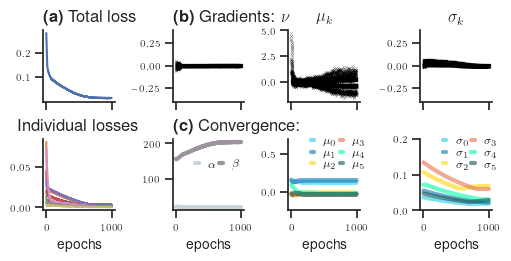

In [15]:
diagnostics_linear(path, file, save_fig = False)

### Elicited statistics according to ground truth

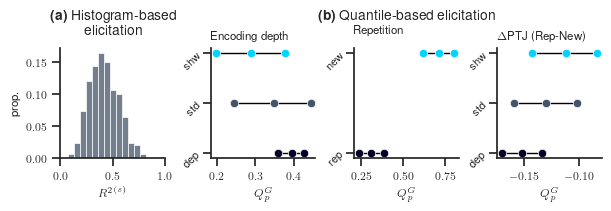

In [14]:
elicited_statistics_normal(path, file, save_fig = False)

### Learned prior distributions

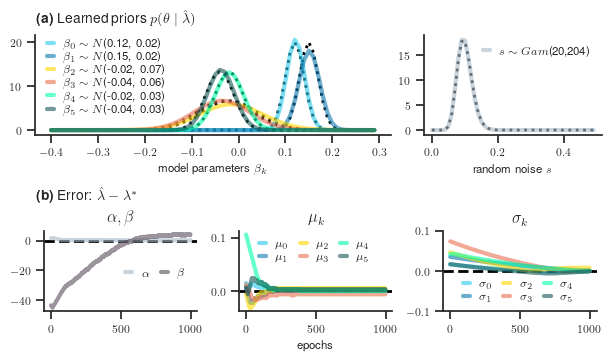

In [17]:
learned_prior_linear(path, file, true_values, 
                      last_vals = 30, save_fig = False)

### Summary output

In [2]:
from setup.write_results import model_summary
import pandas as pd

# get global dictionary
global_dict = pd.read_pickle(path+file+"/global_dict.pkl")

# print summary of method specifications
model_summary(path+file, global_dict)

General summary
---------------- 
method=parametric_prior
sim_id=norm_34765771
seed=34765771
B=128
rep=300
epochs=1000
wall time=99:51 (min:sec)
optimizer=<class 'keras.src.optimizers.adam.Adam'>
learning rate={'lr_scheduler': <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecayRestarts object at 0x0000027C99B1A4F0>, 'init_lr': 0.001, 'decay_steps': 50}

Model info
---------------- 
model name=<class 'user_input.generative_models.GenerativeNormalModel_param'>
model parameters=['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'sigma']

Parametric Prior
---------------- 
distribution family={'b0': 'Normal_log_scale', 'b1': 'Normal_log_scale', 'b2': 'Normal_log_scale', 'b3': 'Normal_log_scale', 'b4': 'Normal_log_scale', 'b5': 'Normal_log_scale', 'sigma': 'Gamma_log'}
initialization={'mu0': {'loc': 0.0, 'scale': 0.1, 'name': 'Normal'}, 'log_sigma0': {'low': -2.0, 'high': -4.0, 'name': 'Uniform'}, 'mu1': {'loc': 0.0, 'scale': 0.1, 'name': 'Normal'}, 'log_sigma1': {'low': -2.0, 'high': -4.0